# <span style="color:blue"> **Assignment 2: Multivariate Linear Regression**</span>

## <span style="color:blue"> **Modules & Packages**</span>

In [42]:
# Pandas: To manipulate DataFrames
import pandas as pd
# Seaborn & Matplotlib: Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# Statsmodels: To estimate our regression model and perform heteroskedatsicity tests
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import statsmodels.stats.diagnostic as smd
# Numpy: For mathematical computations
import numpy as np

## <span style="color:blue"> **The Dataset**</span>

In [43]:
# Creation of the DataFrame from multiple tables stored in an Excel file
sheet = ["Y variable", "x1-market", "x2-value", "x3-small"]
sets = []

data_dict = {}
for title in sheet:
    data_dict[title] = pd.DataFrame(pd.read_excel("TP2-Dataset.xlsx", skiprows = range(6), sheet_name=title).iloc[:]['PX_LAST'])
    data_dict[title][title] = np.log(data_dict[title]['PX_LAST']/data_dict[title]['PX_LAST'].shift(1))
    del data_dict[title]['PX_LAST']
    data_dict[title] = data_dict[title].dropna()
    sets += [data_dict[title]]

df = pd.concat(sets, axis = 1)

In [44]:
name = ['Tech', 'Market', 'Value', 'Size']

ren = {sheet[i]: name for i, name in enumerate(name)}
df = df.rename(columns=ren)

In [45]:
df.head()

,Tech,Market,Value,Size
1,-0.000670,0.001535,-0.004323,-0.030943
2,0.042322,0.056173,0.057936,0.078705
3,0.044298,0.018519,0.018075,0.031858
4,-0.053658,-0.025634,-0.024067,-0.019319
5,0.040666,0.029738,0.035735,0.035507


In [46]:
df.describe()

,Tech,Market,Value,Size
count,517.000000,517.000000,517.000000,517.000000
mean,-0.003133,-0.000783,-0.000799,-0.000167
std,0.031860,0.019804,0.022181,0.027590
min,-0.151192,-0.090930,-0.095603,-0.134211
25%,-0.021413,-0.011619,-0.012017,-0.014185
50%,-0.004975,-0.002268,-0.001781,-0.002370
75%,0.013590,0.007087,0.007886,0.012890
max,0.140315,0.165685,0.211631,0.264327


## <span style="color:blue"> **Multivariate OLS Regression (Non Robust)**</span>

In [47]:
# Define dependant (y) and independent (x) variables
y = df[name[0]]
x = df[name[1:]]

# Add a constant to the predictor variable (intercept)
x = sm.add_constant(x)

# Fit the OLS model to the sample data
model_ols = sm.OLS(y, x).fit()

# View model summary (intercept, coefficient, r-squared)
print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   Tech   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     170.1
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.56e-76
Time:                        22:51:03   Log-Likelihood:                 1227.2
No. Observations:                 517   AIC:                            -2446.
Df Residuals:                     513   BIC:                            -2429.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -2.247      0.0

C:\Users\joelc\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
# Save coefficients to variables
constant = model_ols.params[0]
market, value, size = model_ols.params[1], model_ols.params[2], model_ols.params[3]

## <span style="color:blue"> **Functional Forms**</span>

Text(0, 0.5, 'Tech')

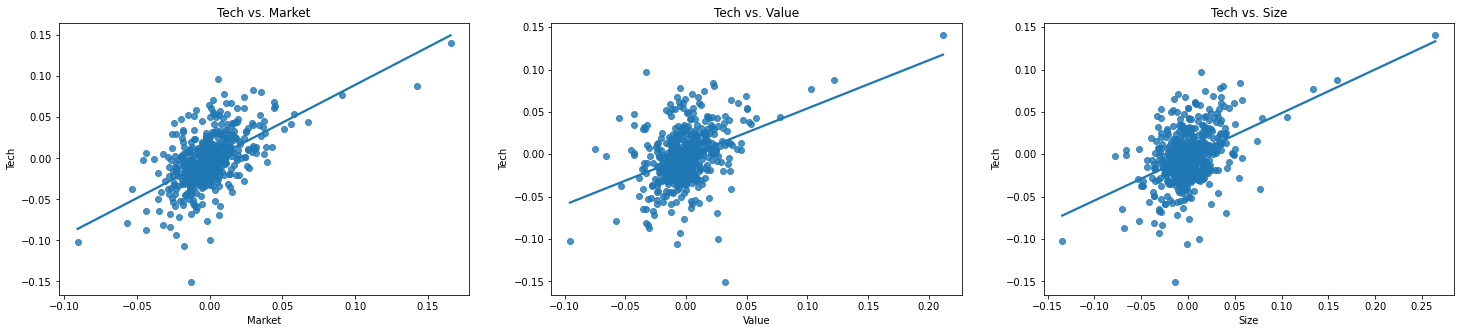

In [49]:
# Plot 3 scatter plots to analyze the shape of the indivdual relationships between "Tech" and each explanatory variable
plt.rcParams["figure.figsize"] = (25,5)

# Tech vs. Market
plt.subplot(1, 3, 1)
sns.regplot(x = df.Market, y = df.Tech, ci = None)
plt.title("Tech vs. Market")
plt.xlabel("Market")
plt.ylabel("Tech")

# Tech vs. Value
plt.subplot(1, 3, 2)
sns.regplot(x = df.Value, y = df.Tech, ci = None)
plt.title("Tech vs. Value")
plt.xlabel("Value")
plt.ylabel("Tech")

# Tech vs. Size
plt.subplot(1, 3, 3)
sns.regplot(x = df.Size, y = df.Tech, ci = None)
plt.title("Tech vs. Size")
plt.xlabel("Size")
plt.ylabel("Tech")

### <span style="color:blue"> **1. Interaction between Value and Size**</span>
The first functional form we'll be exploring will include an interaction term between Size and Value. We have reason to believe that these two variables interact with each other because... . More concretely, here is the equation describing the functional form of interest:

$$ {Tech} = {\beta}_{0} + {\beta}_{1}(Market_{i}) + {\beta}_{2}(Value_{i}) + {\beta}_{3}(Size_{i}) + {\beta}_{4}(Value_{i}*Size_{i}) + {error}_{i} $$

In [50]:
# Estimate the model with a Value * Size interaction term

# Add interaction term to the DataFrame
df_1 = df.copy()
df_1["ValueSize"] = df_1.Market * df_1.Size
df_1.head()

,Tech,Market,Value,Size,ValueSize
1,-0.000670,0.001535,-0.004323,-0.030943,-0.000048
2,0.042322,0.056173,0.057936,0.078705,0.004421
3,0.044298,0.018519,0.018075,0.031858,0.000590
4,-0.053658,-0.025634,-0.024067,-0.019319,0.000495
5,0.040666,0.029738,0.035735,0.035507,0.001056


In [51]:
# Define dependant (y) and independent (x) variables
y_1 = df_1[name[0]]
x_1 = df_1[["Market", "Value", "Size", "ValueSize"]]

# Add a constant to the predictor variable (intercept)
x_1 = sm.add_constant(x_1)

# Fit the OLS model to the sample data
model_int_1 = sm.OLS(y_1, x_1).fit()

# View model summary (intercept, coefficient, r-squared)
print(model_int_1.summary())

                            OLS Regression Results                            
Dep. Variable:                   Tech   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     127.4
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.94e-75
Time:                        22:51:13   Log-Likelihood:                 1227.3
No. Observations:                 517   AIC:                            -2445.
Df Residuals:                     512   BIC:                            -2423.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.001     -2.302      0.0

C:\Users\joelc\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### <span style="color:blue"> **2. Quadratic Form**</span>
The third and final functional form we'll be exploring is the quadratic form. Based on the scatter plots plotted earlier, the relationship between **Tech** and **Market** seems to have a slight curvature. This could be indicative of a quadratic relationship between the two. In this functional form, the quadratic term of the **Market** variable will be added to the original model. More concretely, here is the equation describing the functional form of interest:

$$ Tech = {\beta}_{0} + {\beta}_{1}(Market_{i}) + {\beta}_{2}(Value_{i}) + {\beta}_{3}(Size_{i}) + {\beta}_{4}(Market_{i}^2) + {error}_{i} $$

In [52]:
df_2 = df.copy()
df_2["Market2"] = df_2.Market**2
df_2.head()

,Tech,Market,Value,Size,Market2
1,-0.000670,0.001535,-0.004323,-0.030943,0.000002
2,0.042322,0.056173,0.057936,0.078705,0.003155
3,0.044298,0.018519,0.018075,0.031858,0.000343
4,-0.053658,-0.025634,-0.024067,-0.019319,0.000657
5,0.040666,0.029738,0.035735,0.035507,0.000884


In [54]:
# Define dependant (y) and independent (x) variables
y_2 = df_2[name[0]]
x_2 = df_2[["Market", "Value", "Size", "Market2"]]

# Add a constant to the predictor variable (intercept)
x_2 = sm.add_constant(x_2)

# Fit the OLS model to the sample data
model_quad = sm.OLS(y_2, x_2).fit()

# View model summary (intercept, coefficient, r-squared)
print(model_quad.summary())

                            OLS Regression Results                            
Dep. Variable:                   Tech   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     127.4
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.07e-75
Time:                        22:53:29   Log-Likelihood:                 1227.2
No. Observations:                 517   AIC:                            -2444.
Df Residuals:                     512   BIC:                            -2423.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.001     -2.056      0.0

C:\Users\joelc\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## <span style="color:blue"> **Multivariate OLS Regression (Robust)**</span>

In [9]:
# Statsmodels' RLM function can be used to perform a robust linear regression. The particular method we'll be using is Peter Huber's approach for
# computing heteroskedastic-robust standard errors
ols_robust = sm.RLM(y, x, M = sm.robust.norms.HuberT()).fit()
print(ols_robust.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                   Tech   No. Observations:                  517
Model:                            RLM   Df Residuals:                      513
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sat, 05 Nov 2022                                         
Time:                        22:51:44                                         
No. Iterations:                    18                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.001     -2.466      0.0

## <span style="color:blue"> **Heteroskedasticity Tests**</span>

In [17]:
# Preliminary data preparation

# Create a DF soleley containing the model's independent variables
ivar = df[name[1:]]
# Add a column containing constants to the newly created DF
ivarc = smt.add_constant(data = ivar, prepend = True)
# Verify if the DF was created correctly
ivarc.head()

C:\Users\joelc\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,Market,Value,Size
1,1.0,0.001535,-0.004323,-0.030943
2,1.0,0.056173,0.057936,0.078705
3,1.0,0.018519,0.018075,0.031858
4,1.0,-0.025634,-0.024067,-0.019319
5,1.0,0.029738,0.035735,0.035507


### <span style="color:blue"> **1. Breusch-Pagan Test**</span>
$$ \textbf{Model} $$
$$ \hat{u_{i}}^2 = \hat{\gamma}_{0} + \hat{\gamma}_{1}Market_{i} + \hat{\gamma}_{2}Value_{i} + \hat{\gamma}_{3}Size_{i} + {error}_{i} $$
\
$$ \textbf{Hypothesis} $$
$$ {H}_{0} : {\gamma}_{1} = {\gamma}_{2} = {\gamma}_{3} = 0  $$

In [21]:
# Perform the heteroskedasticity test
bptest = smd.het_breuschpagan(resid = model_ols.resid, exog_het = ivarc)

# Save the test's F-stat as a variable
f_stat = bptest[2]

# Print the test's estimated F-stat
print(f"Breush-Pagan F-Stat: {f_stat}")

Breush-Pagan F-Stat: 6.472991939206945


> The Breusch-Pagan test's estimated F statistic is about 6.47. Given the regression's 513 degrees of freedom and the three restrictions suggested by the null hypothesis, aussuming a 1% significance level, 3.78 can be used as a critical value for this test. Since 6.47 is larger than 3.78, we can reject the null hypothesis at the 1% significance level. Therefore, based on the Breusch-Pagan test, the variance of the population error term differs depending on the values of the explanatory variables, thus rendering our econometric model heteroskedastic.

### <span style="color:blue"> **2. White Test**</span>
$$ \textbf{Model} $$
$$ \hat{u_{i}}^2 = \hat{\gamma}_{0} + \hat{\gamma}_{1}Market_{i} + \hat{\gamma}_{2}Value_{i} + \hat{\gamma}_{3}Size_{i} + \hat{\gamma}_{4}Market_{i}^2 + \hat{\gamma}_{5}Value_{i}^2 + \hat{\gamma}_{6}Size_{i}^2 + \hat{\gamma}_{7}(Market_{i}*Size_{i}) + \hat{\gamma}_{8}(Market_{i}*Value_{i}) + \hat{\gamma}_{9}(Size_{i}*Value_{i}) + {error}_{i} $$
\
$$ \textbf{Hypothesis} $$
$$ {H}_{0} : {\gamma}_{1} = {\gamma}_{2} = ... = {\gamma}_{9} = 0  $$

In [23]:
# Perform the heteroskedasticity test
wtest = smd.het_white(resid = model_ols.resid, exog = ivarc)

# Save the test's F-stat as a variable
f_stat_w = wtest[2]

# Print the test's estimated F-stat
print(f"White F-Stat: {f_stat_w}")

White F-Stat: 11.34392662516576


> The White test's estimated F statistic is about 11.34. Given the regression's 513 degrees of freedom and the 9 restrictions suggested by the null hypothesis, aussuming a 1% significance level, 2.41 can be used as a critical value for this test. Since 11.34 is larger than 2.41, we can reject the null hypothesis at the 1% significance level. Therefore, based on the White test, the variance of the population error term differs depending on the values of the explanatory variables, thus rendering our econometric model heteroskedastic.

## <span style="color:blue"> **Conclusion**</span>
Since both the Breusch-Pagan and the White heteroskedasticity tests suggest that our model is heteroskedastic at the 1% significance level, we can conclude that the theoretical model in fact contains heteriskedasticity.